In [56]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


In [57]:
ds = tfds.load('fashion_mnist', split='train')

In [58]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", 
    "Shirt", "Sneaker", "Bag", "Ankle boot"
]
batch = ds.as_numpy_iterator().next()
label_name = class_names[batch['label']]

In [59]:
dataiterator = ds.as_numpy_iterator()

In [60]:
dataiterator = ds.as_numpy_iterator()
for i in range(9):
    batch = dataiterator.next()
    label = batch['label']
    print(label)

2
1
8
4
1
9
2
2
0


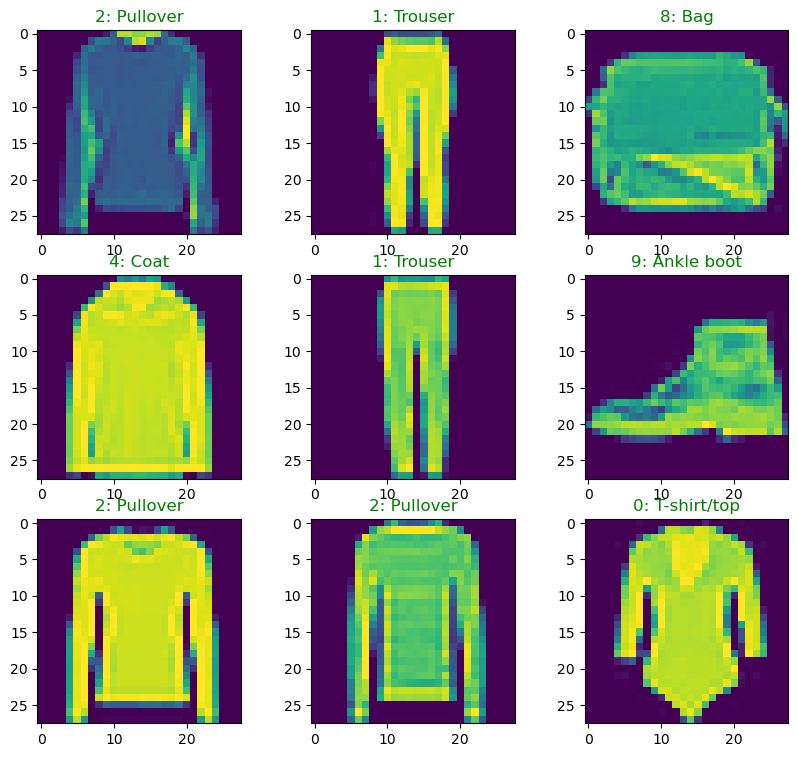

In [61]:
ncols = 3
nrows = 3
dataiterator = ds.as_numpy_iterator()
fig , axis = plt.subplots(ncols, nrows, figsize = (10,9))

for idx in range(ncols*nrows):
    batch = dataiterator.next()
    label = batch['label']
    label_name = class_names[label]
    ax = axis[idx//ncols, idx%ncols]
    ax.imshow(np.squeeze(batch['image']))
    ax.set_title(f'{label}: {label_name}', color = 'green')
plt.show;

In [62]:
def scale_images(data):
    image = data['image']
    return image/255

In [63]:
ds = tfds.load('fashion_mnist', split= 'train')
ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [64]:
len(ds)

469

In [65]:
def build_generator():
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Dense(7*7*128, input_dim = 128))
    #LeakyReLU(0.2): đầu vào nhỏ hơn 0, đầu ra sẽ là 0.2 lần giá trị đó (thay vì 0) để Duy trì tính phi tuyến của dữ liệu.
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Reshape((7,7,128)))
    
    #Upsampling block 1 (làm tăng kích thước dữ liệu)
    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(128,5,padding= 'same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    
    #Upsampling block 2
    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(128, 5, padding= 'same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    
    #Convolutional block 1 xử lí hình ảnh thông qua trích xuất đặc trưng
    model.add(tf.keras.layers.Conv2D(128, 4, padding= 'same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    #Convolutional block 2
    model.add(tf.keras.layers.Conv2D(128, 4, padding= 'same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    
    #sigmoid đảm bảo đầu ra nằm trong khoảng [0,1]
    model.add(tf.keras.layers.Conv2D(1, 4, padding= 'same', activation= 'sigmoid'))
    return model

In [66]:
generator = build_generator()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                      

In [67]:
img = generator.predict(np.random.randn(4,128,1))
len(img)

1/1 [==============================] - 8s 8s/step


4

1/1 [==============================] - 0s 19ms/step


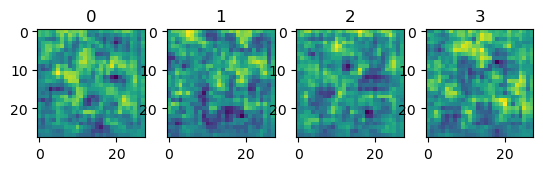

In [68]:
img = generator.predict(np.random.randn(4, 128, 1))

fig, ax = plt.subplots(ncols=4)
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

### **build Descriminator**

Sơ đồ luồng dữ liệu qua mô hình:
Input:

Dữ liệu đầu vào là một ảnh kích thước (28, 28, 1).
Convolutional Layers:

Qua 4 lớp tích chập, ảnh được trích xuất đặc trưng và giảm dần kích thước không gian nhờ các kernel.
Flatten:

Chuyển dữ liệu từ dạng 2D (hình ảnh) sang 1D (vector) để phù hợp với lớp Dense.
Dense Layer:

Lớp cuối cùng đưa ra một giá trị dự đoán, quyết định ảnh đầu vào là thật hay giả.

In [69]:
def build_discriminator():
    model = tf.keras.models.Sequential()
    
    model.add(tf.keras.layers.Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Conv2D(64, 5))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Conv2D(128, 5))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Conv2D(256, 5))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.4))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(1, activation= 'sigmoid'))
    
    
    return model

In [70]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 128)      

In [71]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

Generator (g) cần một tốc độ học cao hơn để nhanh chóng cải thiện chất lượng hình ảnh giả, nhưng không quá cao để tránh sự mất ổn định trong quá trình huấn luyện.

Discriminator (d) cần một tốc độ học thấp hơn để tinh chỉnh một cách ổn định và chính xác khả năng phân biệt giữa hình ảnh thật và giả, tránh việc cập nhật tham số quá nhanh.

In [72]:
g_opt = Adam(learning_rate = 0.0001)
d_opt = Adam(learning_rate = 0.00001)

g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [73]:
from tensorflow.keras.models import Model

In [74]:

class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
        
    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training = False)
        
        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training = True)
            yhat_fake = self.discriminator(fake_images, training = True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis = 0)
            
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis =0)
            
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake =-0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake+= tf.concat([noise_real, noise_fake], axis=0)
            
            total_d_loss = self.d_loss(y_realfake, yhat_fake)
            
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        with tf.GradientTape () as g_tape:
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)
            
            predicted_labels = self.discriminator(gen_images, training = False)
            
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
            
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"dloss":total_d_loss, "gloss":total_g_loss}
        

In [75]:
fashgan = FashionGAN(generator, discriminator)

In [ ]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [77]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [78]:
os.makedirs('GANimages', exist_ok= True)
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim =  latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generator_images = self.model.generator(random_latent_vectors)
        generator_images *= 255
        generator_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generator_images[i])
            img.save(os.path.join('GANimages', f'generated_img_{epoch}_{i}.png'))

In [80]:
hist = fashgan.fit(ds, epochs=1, callbacks= [ModelMonitor()])

KeyboardInterrupt: 